In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=4)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 58.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46639,Workers: 4
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.87 GiB
Comm: tcp://127.0.0.1:34931,Total threads: 4
Dashboard: /user/jbusecke/proxy/35859/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:37963,


In [2]:
import gcsfs
import xarray as xr
import numpy as np
import cartopy
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram


from scale_aware_air_sea.utils import open_zarr, filter_inputs_dataset
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26
from scale_aware_air_sea.parameters import get_params

from xarrayutils.plotting import shaded_line_plot
%matplotlib inline

In [3]:
# load global parameters
params = get_params('v0.7.0', test=False) 
projection = cartopy.crs.Robinson(200)
primary_algo = 'ecmwf'
n_subsample = 4
subsample = dict(xt_ocean=slice(0, None, n_subsample), yt_ocean=slice(0,None, n_subsample))

fs = gcsfs.GCSFileSystem()

mapper_filter_flux_decomposition_daily = fs.get_mapper(params['paths']['CM26']['filter_decomposition_daily'])
ds_small_scale_daily = open_zarr(mapper_filter_flux_decomposition_daily)

mapper_filter_input = fs.get_mapper(params['paths']['CM26']['filter'])
ds_filtered = open_zarr(mapper_filter_input).rename({'surface_temp_filtered':'surface_temp'})[['surface_temp']]

ds_raw = load_and_combine_cm26(fs, inline_array=True)

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


In [8]:
def filter(ds):
    return filter_inputs_dataset(
        ds, 
        ['yt_ocean', 'xt_ocean'], 
        params['filter_scale'], 
        filter_type=params['filter_type'],
    )

tt = 0

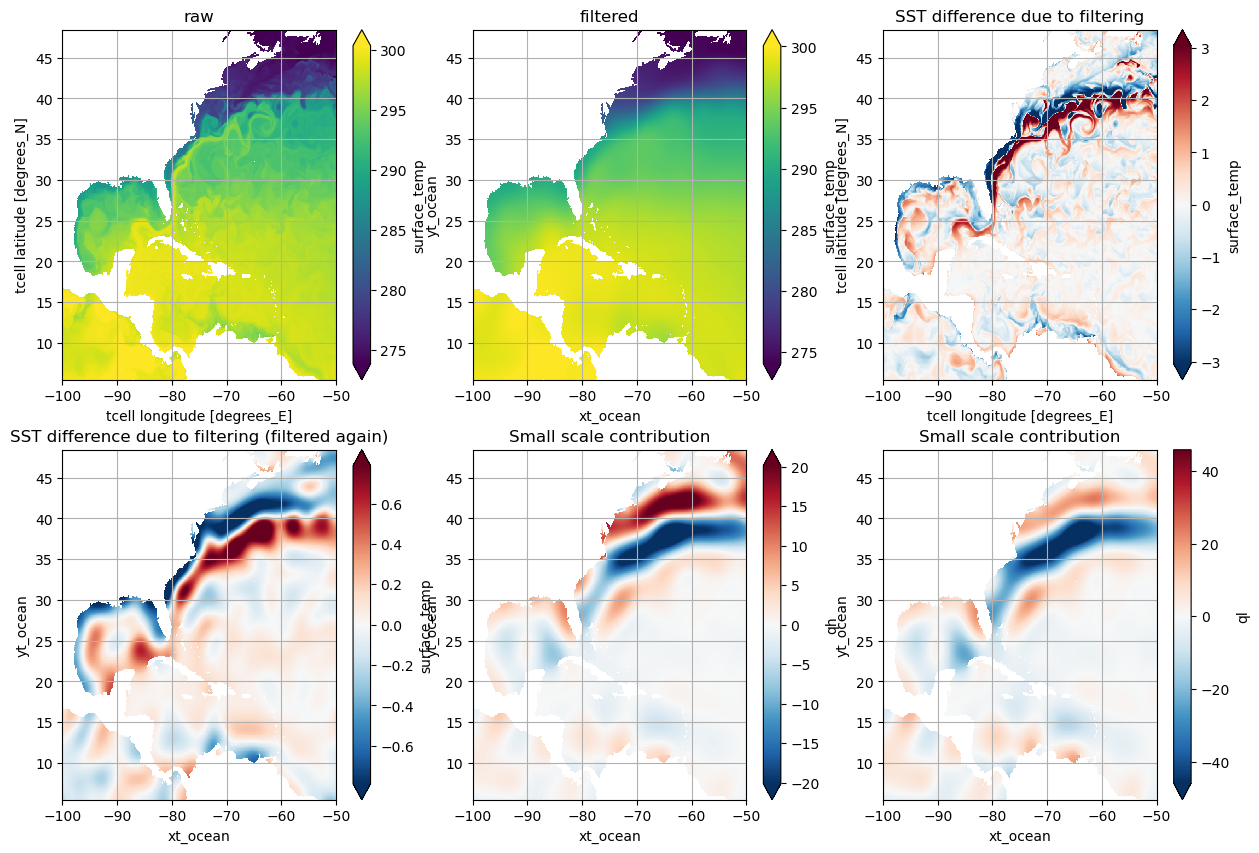

In [12]:
roi = dict(time=tt, xt_ocean=slice(1800, 2300), yt_ocean=slice(1300, 1800))

def filter(ds):
    return filter_inputs_dataset(
        ds, 
        ['yt_ocean', 'xt_ocean'], 
        params['filter_scale'], 
        filter_type=params['filter_type'],
    )
da_small = ds_small_scale_daily.isel(**roi, algo=0).sel(term='Q_star_star_ocean')
da_filtered = ds_filtered['surface_temp'].isel(**roi)
da_raw = ds_raw['surface_temp'].isel(**roi)
da_difference = filter(ds_raw.isel(**roi) - ds_filtered.isel(**roi))['surface_temp']
da_difference_raw = ds_raw.isel(**roi)['surface_temp'] - ds_filtered.isel(**roi)['surface_temp']

p_kwargs = dict(x='xt_ocean', robust=True)

plt.figure(figsize=[15, 10])
plt.subplot(2,3,1)
da_raw.plot(**p_kwargs)
plt.title('raw')
plt.grid()

plt.subplot(2,3,2)
da_filtered.plot(**p_kwargs)
plt.title('filtered')
plt.grid()

plt.subplot(2,3,3)
da_difference_raw.plot(**p_kwargs)
plt.title('SST difference due to filtering')
plt.grid()

plt.subplot(2,3,4)
da_difference.plot(**p_kwargs)
plt.title('SST difference due to filtering (filtered again)')
plt.grid()

plt.subplot(2,3,5)
da_small['qh'].plot(**p_kwargs)
plt.title('Small scale contribution')
plt.grid()

plt.subplot(2,3,6)
da_small['ql'].plot(**p_kwargs)
plt.title('Small scale contribution')
plt.grid()

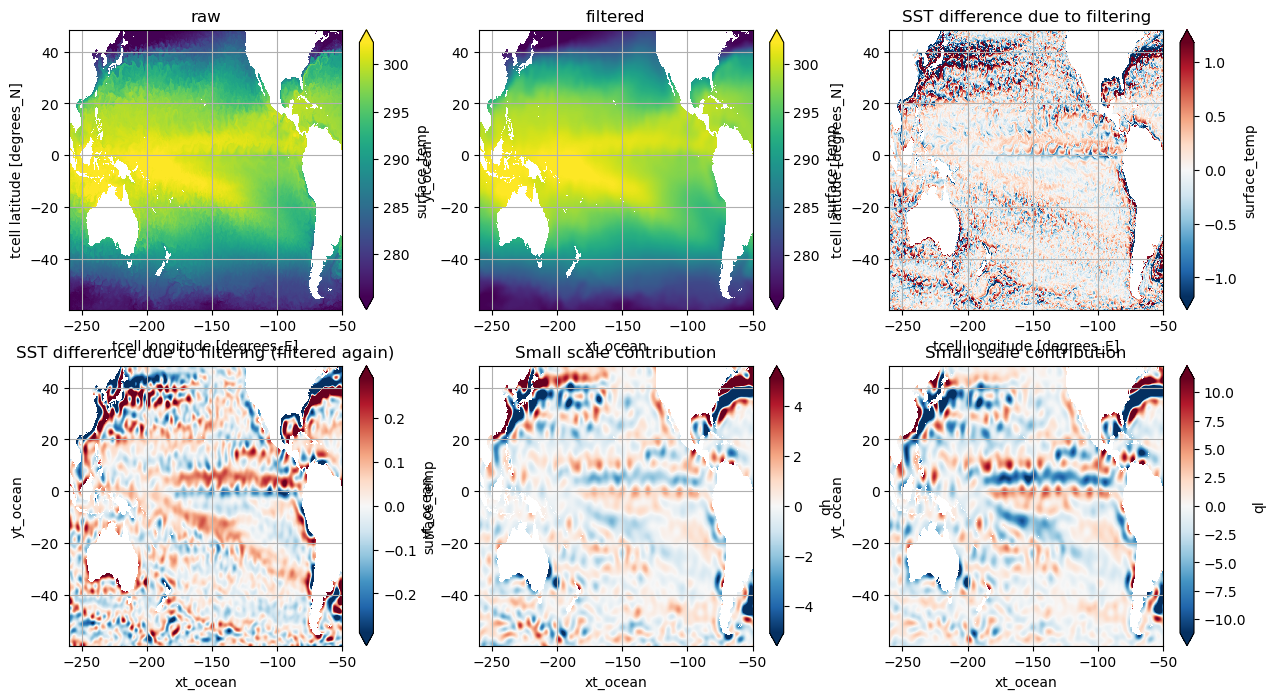

In [10]:
roi = dict(time=tt, xt_ocean=slice(200, 2300), yt_ocean=slice(500, 1800))

da_small = ds_small_scale_daily.isel(**roi, algo=0)
da_filtered = ds_filtered['surface_temp'].isel(**roi)
da_raw = ds_raw['surface_temp'].isel(**roi)
da_difference = filter(ds_raw.isel(**roi) - ds_filtered.isel(**roi))['surface_temp']
da_difference_raw = ds_raw.isel(**roi)['surface_temp'] - ds_filtered.isel(**roi)['surface_temp']

p_kwargs = dict(x='xt_ocean', robust=True)

plt.figure(figsize=[15, 8])
plt.subplot(2,3,1)
da_raw.plot(**p_kwargs)
plt.title('raw')
plt.grid()

plt.subplot(2,3,2)
da_filtered.plot(**p_kwargs)
plt.title('filtered')
plt.grid()

plt.subplot(2,3,3)
da_difference_raw.plot(**p_kwargs)
plt.title('SST difference due to filtering')
plt.grid()

plt.subplot(2,3,4)
da_difference.plot(**p_kwargs)
plt.title('SST difference due to filtering (filtered again)')
plt.grid()

plt.subplot(2,3,5)
da_small['qh'].plot(**p_kwargs)
plt.title('Small scale contribution')
plt.grid()

plt.subplot(2,3,6)
da_small['ql'].plot(**p_kwargs)
plt.title('Small scale contribution')
plt.grid()

Nice. This lines up very neatly as positive anomalies in small scale sst show negative (enhanced flux) anomalies in both sensible and latent heatflux.

In [ ]:
# long_term mean 'small scale SST'
small_sst = filter((ds_raw - ds_filtered))['surface_temp'].mean('time').load()